In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# silence warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [4]:
! ../../keras-retinanet/keras_retinanet/bin/train.py --weights ../Data/snapshots_roboflow2_2/resnet50_csv_07.h5 \
--batch-size 2 --steps 1956 --epochs 20 \
--snapshot-path ../Data/snapshots_roboflow2_3 \
--random-transform \
--config ../roboflow2/elephant_config.ini \
csv ../roboflow2/train/annotations_final.csv ../Data/elephant_classes.csv \
--val-annotations ../roboflow2/valid/annotations_final.csv

Using TensorFlow backend.
Creating model, this may take a second...
Model: "retinanet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, None, None, 6 0           bn_conv1[0][0]                   
______________________

In [11]:
# convert the model weights to a usable format
! ../../keras-retinanet/keras_retinanet/bin/convert_model.py --config ../roboflow2/elephant_config.ini  ../Data/snapshots_roboflow2_3/resnet50_csv_10.h5 ../Data/model_twenty_epochs.h5
# run the model on test set
! ../../keras-retinanet/keras_retinanet/bin/evaluate.py csv ../roboflow2/test/annotations_final.csv ../Data/elephant_classes.csv ../Data/model_twenty_epochs.h5
# the above is for the last epoch



Using TensorFlow backend.
Loading model, this may take a second...
Running network: 100% (467 of 467) |#####| Elapsed Time: 0:03:31 Time:  0:03:31
Parsing annotations: 100% (467 of 467) |#| Elapsed Time: 0:00:00 Time:  0:00:00
159 instances of class bull with average precision: 0.8443
781 instances of class cow with average precision: 0.9375
2152 instances of class pup with average precision: 0.9694
Inference time for 467 images: 0.4383
mAP using the weighted average of precisions among classes: 0.9549
mAP: 0.9170


In [12]:
# convert the model weights to a usable format
! ../../keras-retinanet/keras_retinanet/bin/convert_model.py --config ../roboflow2/elephant_config.ini  ../Data/snapshots_roboflow2_3/resnet50_csv_01.h5 ../Data/model_ten_epochs.h5
# run the model on test set
! ../../keras-retinanet/keras_retinanet/bin/evaluate.py csv ../roboflow2/test/annotations_final.csv ../Data/elephant_classes.csv ../Data/model_ten_epochs.h5
# the above is for epoch 10



Using TensorFlow backend.
Using TensorFlow backend.
Loading model, this may take a second...
Running network: 100% (467 of 467) |#####| Elapsed Time: 0:04:27 Time:  0:04:27
Parsing annotations: 100% (467 of 467) |#| Elapsed Time: 0:00:00 Time:  0:00:00
159 instances of class bull with average precision: 0.8377
781 instances of class cow with average precision: 0.9358
2152 instances of class pup with average precision: 0.9651
Inference time for 467 images: 0.5579
mAP using the weighted average of precisions among classes: 0.9511
mAP: 0.9129


In [3]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

import keras

from keras_retinanet.models import retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import json
from random import shuffle

import tensorflow as tf

def get_session():
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.compat.v1.Session(config=config)

tf.compat.v1.keras.backend.set_session(get_session())

Using TensorFlow backend.


In [4]:
model_path = '../Data/model_ten_epochs.h5'

print(model_path)

model = models.load_model(model_path, backbone_name='resnet50')

#print(model.summary())

labels_to_names = {0: 'bull', 1: 'cow', 2: 'pup'}

../Data/model_ten_epochs.h5


In [5]:
image_dir = "../roboflow2/test/"

# image_list = []
# for root, dirs, files in os.walk(image_dir):
#     for filename in files:
#         if filename.lower().endswith(('.jpg')):
#             image_list.append(image_dir + filename)
image_list =[
    "../roboflow2/test/4MSL0119-65_png.rf.d1867f6e9b212d3fde1984a9ace2b0e9.jpg",
    "../roboflow2/test/4MSL0120-10_png.rf.d7e4dde6fca786b38a467967a12a9f5f.jpg",
    "../roboflow2/test/5MSL0009-69_png.rf.d47e8e59fa4eef836663d49ed534298e.jpg",
    "../roboflow2/test/5MSL0013-71_png.rf.e30cfab19be767af58fa1a9e6e2ff992.jpg",
    "../roboflow2/test/5MSL0013-71_png.rf.e30cfab19be767af58fa1a9e6e2ff992.jpg",
    "../roboflow2/test/5MSL0068-40_png.rf.2bceac42d9f1398bf98a2f0c56abb90d.jpg",
    "../roboflow2/test/5MSL0069-28_png.rf.5b9e4fd8bd56ecbca0b121ff7228a681.jpg",
    "../roboflow2/test/5MSL0108-109_png.rf.2acfd0850dad5036553c52250ef993b8.jpg",
    "../roboflow2/test/5MSL1483-126_png.rf.47c220033dcfcb1c0a8fe93071b741d5.jpg"
]
print(len(image_list))

9


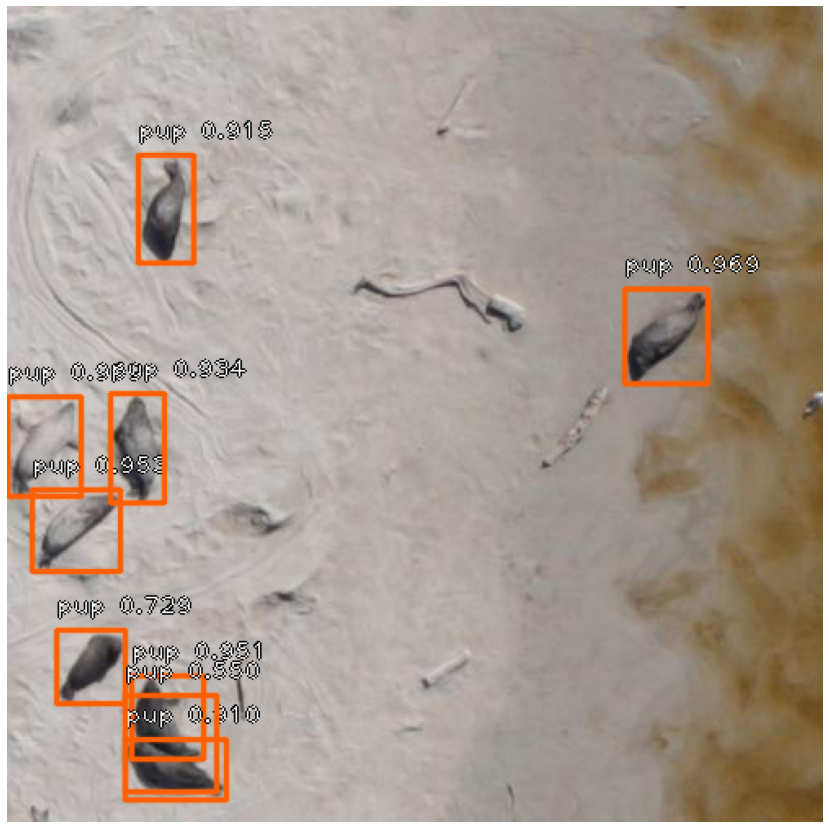

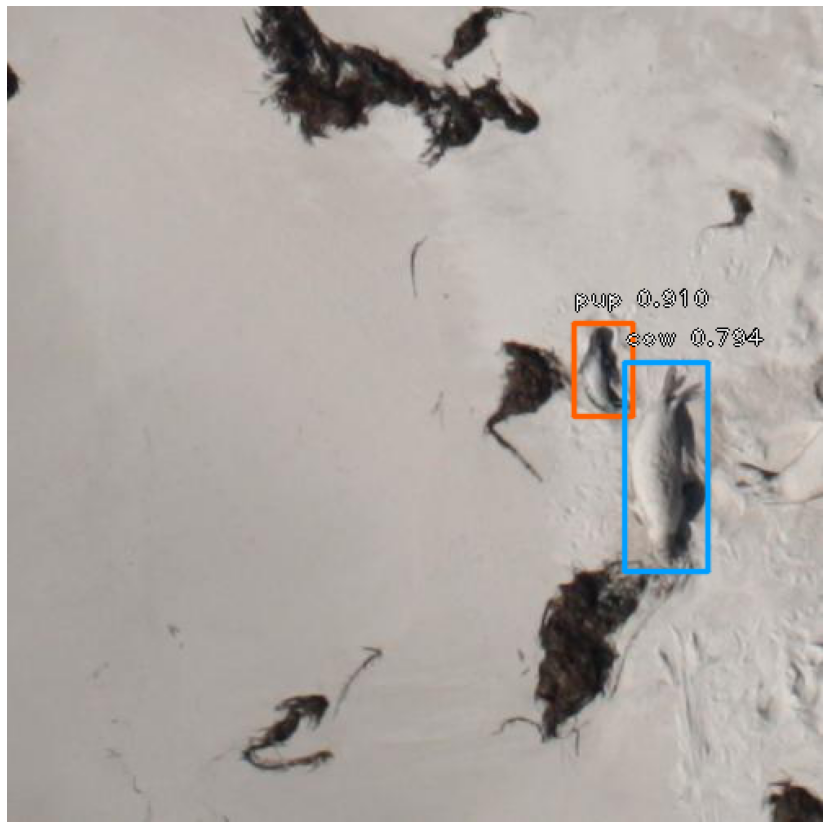

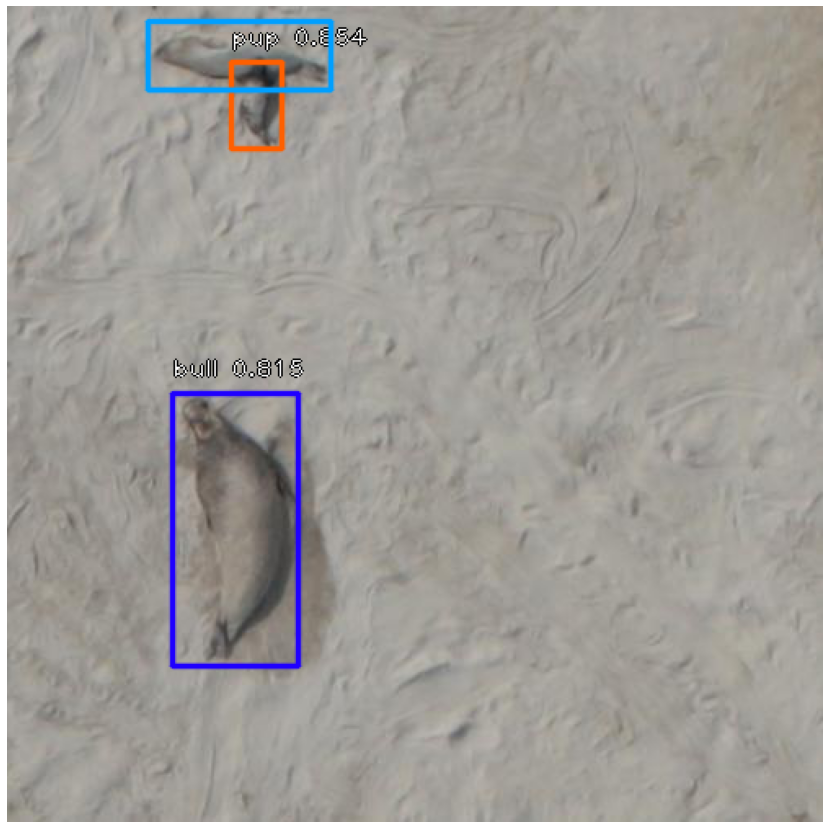

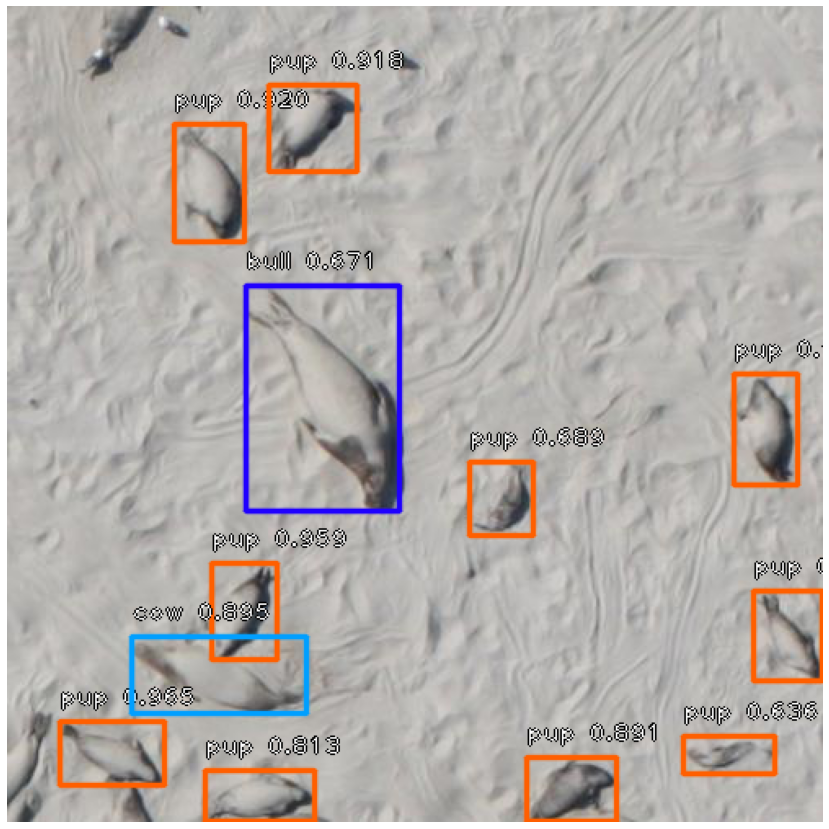

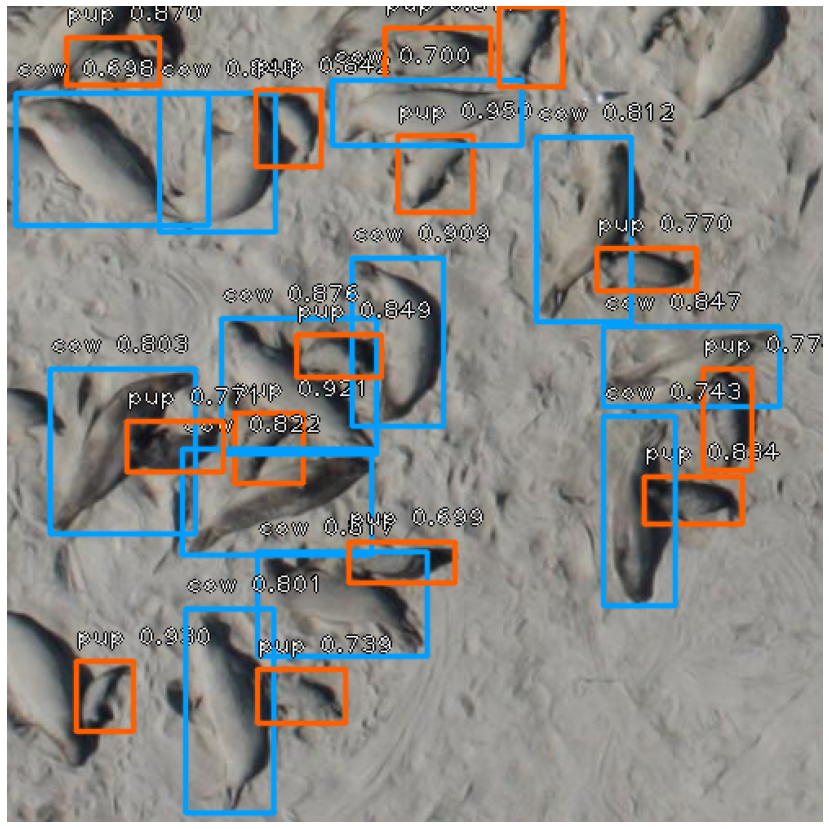

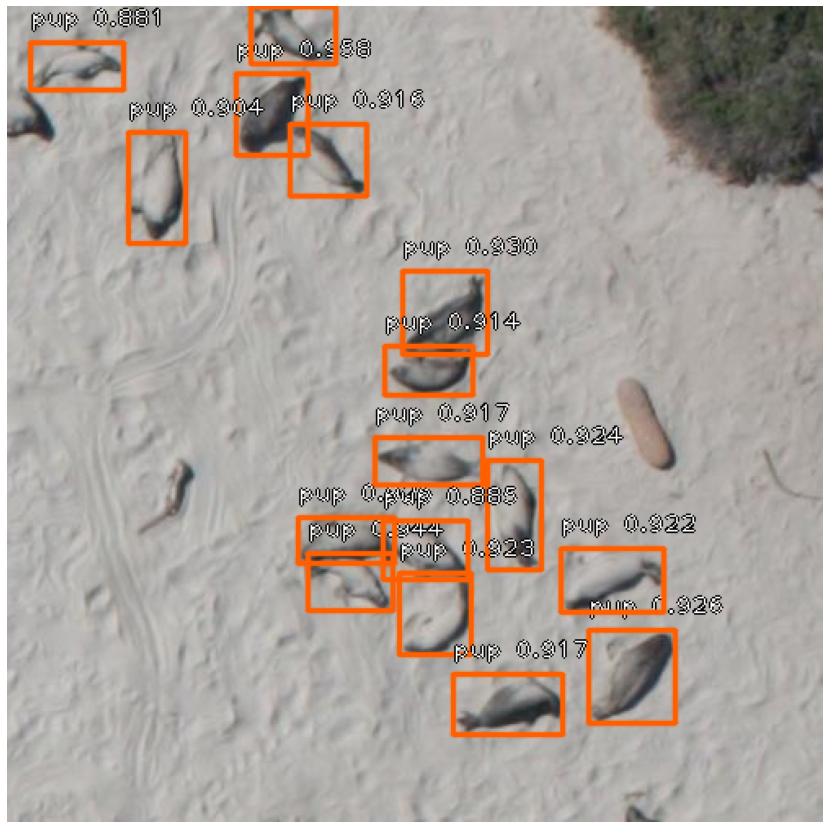

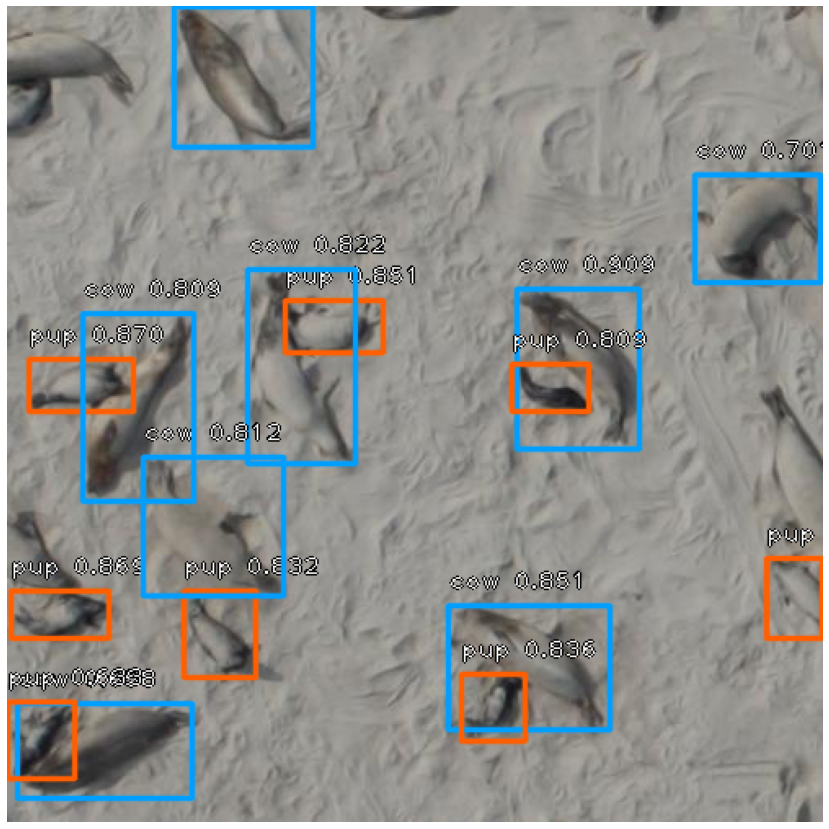

Finished, time per image: 0.035723739200168185


In [8]:
visualize = True
min_score = 0.5

detections = {}

total_time = 0

count = 0
detection_iterations = 10
shuffle(image_list)

for image_path in image_list: 
    if count > detection_iterations:
        break
    else: 
        count +=1
    
    image = read_image_bgr(image_path)
    
    if visualize:
        draw = image.copy()
        draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
        
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    total_time += time.time() - start 
    
    boxes /= scale
    if any(score >= min_score for score in scores [0]):
        detections[image_path] = []
    
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < min_score:
            break
        
        b = box.astype(int)
        detections[image_path].append({"box" : b, "label" : label, "score" : score})
        
        if visualize: 
            color = label_color(label)
            
            draw_box(draw, b, color=color)
            
            caption = "{} {:.3f}".format(labels_to_names[label], score)
            draw_caption(draw, b, caption)
            
    if any(score >= min_score for score in scores[0]):
        if visualize:
            plt.figure(figsize=(15, 15))
            plt.axis('off')
            plt.imshow(draw)
            plt.show()
            
print("Finished, time per image:", total_time/len(image_list))

In [11]:
image_dir = "../roboflow2/test/"

image_list = []
for root, dirs, files in os.walk(image_dir):
    for filename in files:
        if filename.lower().endswith(('.jpg')) and "checkpoint" not in filename:
            image_list.append(image_dir + filename)
print(len(image_list))

977


In [12]:
min_score = 0.5

detections = {}

total_time = 0

for image_path in image_list:
    
    image = read_image_bgr(image_path)
          
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    total_time += time.time() - start
    
    boxes /= scale  
        
    if any(score >= min_score for score in scores[0]):
        detections[image_path] = []
        
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < min_score:
            break
        
        b = box.astype(int)    
        detections[image_path].append({"box" : b, "label" : label, "score" : score})
        
            
print("Finished, time per image:", total_time/len(image_list))

Finished, time per image: 0.03334141094828579


In [13]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [15]:
with open('../Data/test_detections.json', 'w') as fp:
    json.dump(detections, fp, cls=MyEncoder)